<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/hw6/Homework/hw6/Homework6_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw6/data
!rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 235 (delta 106), reused 213 (delta 89), pack-reused 0
Receiving objects: 100% (235/235), 30.56 MiB | 26.17 MiB/s, done.
Resolving deltas: 100% (106/106), done.
--2021-12-08 12:36:41--  https://docs.google.com/uc?export=download&confirm=_iCo&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 142.250.153.100, 142.250.153.113, 142.250.153.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.153.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-5s-docs.googleusercontent.com/docs/securesc/cp7285vo0rq2mqhav0n2ci04sce114je/stvmp3sqgsk4bj9kf3b5g77a1u4h6lej/1638966975000/06419056966375271799/02187571630514203078Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2021-12-08 12:36:41--  https://doc-0o-5s-doc

In [53]:
from dul_2021.utils.hw6_utils import *

# Question 1: VAEs on Images
In this question, you will train VAE model on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

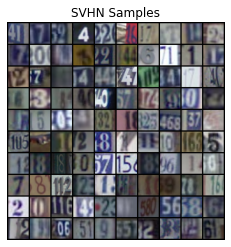

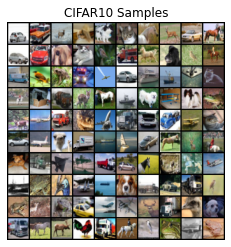

In [54]:
visualize_svhn()
visualize_cifar10()

## VAE with AF Prior
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as in homework 5. For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [55]:
import torch
import torch.nn as nn

from torch.distributions import Normal
from torch.utils.data import DataLoader

from tqdm.auto import tqdm, trange

def device():
    return "cuda" if torch.cuda.is_available() else "cpu"


class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(mask)
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)
        

class MADEAF(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.model = nn.Sequential(
            MaskedLinear(input_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, 2 * output_dim)
        )
        masks = self.sample_masks(num_layers=2)

        for i, linear in enumerate(self.model[::2]):
            linear.set_mask(masks[i].T)

        self.base_dist = Normal(
            torch.tensor(0, dtype=torch.float, device=device()),
            torch.tensor(1, dtype=torch.float, device=device())
        )

    def sample_masks(self, num_layers):
        masks = []
        ids = {-1: torch.arange(self.input_dim)}
        
        for l in range(num_layers):
            ids[l] = torch.randint(ids[l - 1].min(), self.input_dim - 1, size=(self.hidden_dim,))
            masks.append(ids[l - 1][:, None] <= ids[l][None, :])

        last_mask = torch.repeat_interleave(ids[num_layers - 1][:, None] < ids[-1][None, :], 2, dim=1)
        masks.append(last_mask)

        return masks

    def forward(self, z):
        out = self.model(z).view(-1, self.input_dim, 2)
        mu, log_sigma = torch.chunk(out, 2, dim=-1) # [batch, 16, 2] -> [batch, 16]
        
        return mu.squeeze(), log_sigma.squeeze()

    def flow(self, z):
        mu, log_sigma = self.forward(z)

        return z * log_sigma.exp() + mu, log_sigma

    def inverse_flow(self, e, mu, log_sigma):
        return (e - mu) * (-log_sigma).exp()

    def log_prob(self, z):
        e, log_det = self.flow(z)

        return self.base_dist.log_prob(e) + log_det

In [5]:
class VAE32(nn.Module):
    def __init__(self, input_channels, latent_dim=16, beta=1.0):
        super().__init__()
        self.beta = beta
        self.latent_dim = latent_dim

        self.made_prior = MADEAF(input_dim=16, output_dim=16, hidden_dim=512)
        
        # hardcoded layers for imgs 32x32
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),  # 16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 4
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 2
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 1
            nn.ReLU(),
            nn.Conv2d(512, 2 * latent_dim, kernel_size=1, stride=1, padding=0)
        ) 
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, 512, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1)
        )

        print(sum([p.numel() for p in self.parameters()]))

    def forward(self, x):
        mu, log_sigma = self.encode(x)
        z = self.reparameterize(mu, log_sigma)
        new_x = self.decode(z)
        return new_x, (z, mu, log_sigma)

    def encode(self, x):
        mu, log_sigma = torch.chunk(self.encoder(x), 2, dim=1)
        return mu, log_sigma

    def reparameterize(self, mu, log_sigma):
        return mu + torch.randn_like(log_sigma) * torch.exp(log_sigma)

    def decode(self, z):
        return self.decoder(z)

    def _loss(self, batch):
        recon_batch, (z, mu, log_sigma) = self.forward(batch)
        q_dist = Normal(mu, log_sigma.exp())

        recon_loss = F.mse_loss(recon_batch, batch.detach(), reduction="none").view(batch.shape[0], -1).sum(dim=1).mean()
        kl_loss = (q_dist.log_prob(z).flatten(1) - self.made_prior.log_prob(z.flatten(1))).sum(dim=1).mean()  # the only change for loss

        total_loss = recon_loss + self.beta * kl_loss

        return total_loss, recon_loss, kl_loss

    def fit(self, train_dataloader, test_dataloader, epochs, lr):
        loss_info = {
            "test": [self.test(test_dataloader)], 
            "train": [],
          }

        optim = torch.optim.Adam(self.parameters(), lr=lr)

        for _ in trange(epochs, desc="Training"):
            for batch in train_dataloader:
                batch = batch.to(device())

                total_loss, recon_loss, kl_loss = self._loss(batch)

                optim.zero_grad()
                total_loss.backward()
                optim.step()

                loss_info["train"].append([total_loss.item(), recon_loss.item(), kl_loss.item()])
            loss_info["test"].append(self.test(test_dataloader))

        loss_info["train"] = np.array(loss_info["train"])
        loss_info["test"] = np.array(loss_info["test"])

        return loss_info

    @torch.no_grad()
    def test(self, test_dataloader):
        total, recon, kl = [], [], []
        for batch in tqdm(test_dataloader, desc="Testing", leave=False):
            batch = batch.to(device())

            total_loss, recon_loss, kl_loss = self._loss(batch)

            total.append(total_loss.item())
            recon.append(recon_loss.item())
            kl.append(kl_loss.item())

        return np.mean(total), np.mean(recon), np.mean(kl)

    @torch.no_grad()
    def sample(self, n):
        z = torch.randn(n, self.latent_dim, device=device())

        for i in range(self.latent_dim):
            mu, log_sigma = self.made_prior(z)
            mu, log_sigma = mu[:, i], log_sigma[:, i]

            z[:, i] = self.made_prior.inverse_flow(z[:, i], mu, log_sigma)
        
        # z = torch.randn(n, 16).to(device())  # если так, то все ок
        samples = self.decode(z.unsqueeze(-1).unsqueeze(-1)) 
        
        return samples.cpu().numpy().transpose(0, 2, 3, 1)

In [ ]:
test_model = VAE32(3).to(device())
test_batch = torch.ones((8, 3, 32, 32), device=device())

test_model._loss(test_batch)
# test_model.sample(n=10).shape

4668771


(tensor(3193.4016, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(3193.3691, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    train_data = 2 * (np.transpose(train_data, (0, 3, 1, 2)) / 255.0).astype('float32') - 1
    test_data = 2 * (np.transpose(test_data, (0, 3, 1, 2)) / 255.0).astype('float32') - 1

    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=128)
    
    model = VAE32(3, latent_dim=16, beta=1.0).to(device())
    losses = model.fit(train_dataloader, test_dataloader, epochs=25, lr=1e-3)

    samples = (np.clip(model.sample(100), -1, 1) * 0.5 + 0.5) * 255.0

    test_imgs = next(iter(test_dataloader))[:50].to(device())  # mb just from test_data?
    with torch.no_grad():
        recon_imgs = torch.clip(model(test_imgs)[0], -1, 1) # 0 1

    recons = (torch.vstack((test_imgs, recon_imgs)).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5) * 255
    
    test_imgs = next(iter(test_dataloader))[:20].to(device())
    with torch.no_grad():
        z = model.reparameterize(*model.encode(test_imgs))
        z1, z2 = z.chunk(2, dim=0)
        
        interps = [model.decode(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = (torch.clip(torch.stack(interps, dim=1).view(-1, 3, 32, 32), -1, 1) * 0.5 + 0.5) * 255
        interps = interps.cpu().numpy().transpose(0, 2, 3, 1)

    return losses["train"], losses["test"], samples, recons, interps

### Results
Once you've finished `q1`, execute the cells below to visualize and save your results.

4668771


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Final -ELBO: 115.5278, Recon Loss: 97.5361, KL Loss: 17.9917


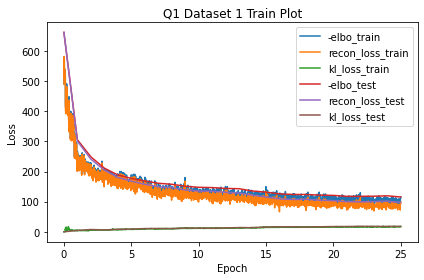

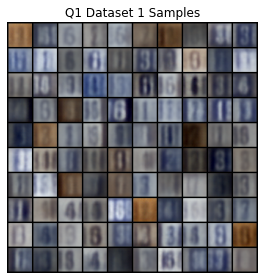

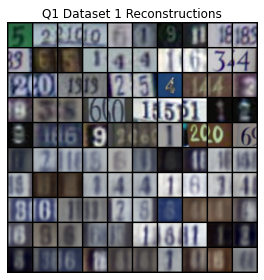

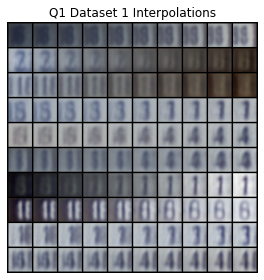

In [ ]:
q1_save_results(1, q1)

4668771


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Final -ELBO: 238.6482, Recon Loss: 209.3298, KL Loss: 29.3184


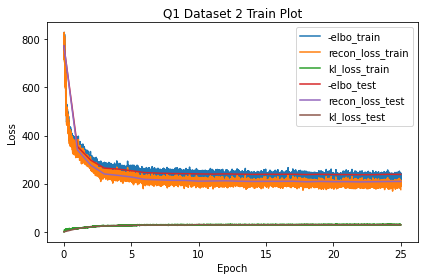

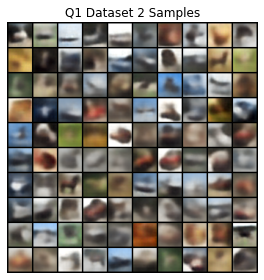

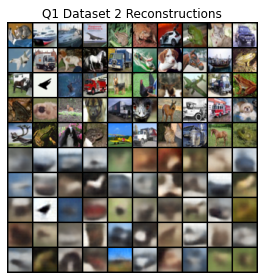

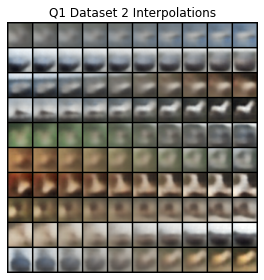

In [ ]:
q1_save_results(2, q1)

# Question 2: VQ-VAE
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

# PixelCNN

In [111]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()

    def _set_independent_mask(self, typeB=0):  # type = {0: A, 1: B}
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + typeB] = 1
        self.mask[:, :, :h // 2] = 1

    def forward(self, x, cond=None):
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError

class ConvA(MaskedConv2d):
    def set_mask(self):
        self._set_independent_mask(typeB=False)

class ConvB(MaskedConv2d):
    def set_mask(self):
        self._set_independent_mask(typeB=True)


class PixelResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        hidden_channels = in_channels // 2
        self.model = nn.Sequential(
            nn.ReLU(),
            ConvB(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1),
            nn.ReLU(),
            ConvB(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=7, padding=3),
            nn.ReLU(),
            ConvB(in_channels=hidden_channels, out_channels=in_channels, kernel_size=1),
        )
    
    def forward(self, x):
        return x + self.model(x)


class PixelCNN(nn.Module):
    def __init__(self, in_size, in_channels, hidden_channels=120, num_bins=4, num_blocks=8):
        super().__init__()
        self.in_size = in_size
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.num_bins = num_bins

        self.embedding = nn.Embedding(num_bins, in_channels)
        self.model = self.setup_model()

    def setup_model(self):
        model = [
            ConvA(in_channels=self.in_channels, out_channels=self.hidden_channels, kernel_size=7, padding=3),
        ]
        for _ in range(self.num_blocks):
          model.extend([nn.ReLU(), PixelResidualBlock(in_channels=self.hidden_channels)])
        model.extend([nn.ReLU(), ConvB(in_channels=self.hidden_channels, out_channels=self.hidden_channels, kernel_size=1)])
        model.extend([nn.ReLU(), ConvB(in_channels=self.hidden_channels, out_channels=self.in_channels * self.num_bins, kernel_size=1)])
        
        return nn.Sequential(*model)

    def forward(self, x):
        x = self.embedding(x.squeeze(1)).permute(0, 3, 1, 2)
        b, c, h, w = x.shape
        
        return self.model(x).reshape(b, c, self.num_bins, h, w).permute(0, 2, 1, 3, 4) 

    def _loss(self, batch):
        batch = batch.to(device())
        loss = F.cross_entropy(self.forward(batch), batch.long().detach())
        return loss

    @torch.no_grad()
    def sample(self, num_samples, seed=None):
        if seed is not None:
            torch.manual_seed(seed)

        result = torch.zeros((num_samples, self.in_channels, self.in_size, self.in_size)).to(device())
        for i in range(self.in_size):
            for j in range(self.in_size):
                probs = self.predict_proba(result)[..., i, j]
                
                for c in range(self.in_channels):
                    result[:, c, i, j] = torch.multinomial(probs[..., c], num_samples=1).flatten()
        
        return result

    @torch.no_grad()
    def predict_proba(self, x):
        return F.softmax(self.forward(x), dim=1)

    @torch.no_grad()
    def test(self, test_dataloader):
        self.eval()
        losses = []
        for batch in tqdm(test_dataloader, desc="Testing", leave=False):
            loss = self._loss(batch)
            losses.append(loss.item())
        self.train()
        return np.mean(losses)

    def fit(self, train_dataloader, test_dataloader, epochs=20, lr=1e-3, grad_clip=None):
        optim = torch.optim.Adam(self.parameters(), lr=lr)

        loss_info = {"train": [], "test": [self.test(test_dataloader)]}
        for epoch in trange(epochs, desc="Training"):
            losses = []
            for batch in tqdm(train_dataloader, desc="Batches", leave=False):
                loss = self._loss(batch)
                losses.append(loss.item())

                optim.zero_grad()
                loss.backward()
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                optim.step()

            loss_info["train"].append(np.mean(losses))
            loss_info["test"].append(self.test(test_dataloader))

        return loss_info

# VQ-VAE

In [100]:
class ResidualBlock2d(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(input_dim),
            nn.Conv2d(input_dim, input_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(input_dim),
            nn.Conv2d(input_dim, input_dim, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        return x + self.model(x)


class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1. / num_embeddings, 1. / num_embeddings)

        self.beta = beta

    def forward(self, Z):
        E = self.embedding.weight

        with torch.no_grad():
            distance = torch.sum(Z**2, dim=1, keepdim=True) + torch.sum(E**2, dim=1) - 2 * Z @ E.t()  # (x - y)^2 = x^2 + y^2 - 2xy
            indices = torch.argmin(distance, dim=-1)
        
        quantized = self.embedding(indices)

        return quantized, (quantized - Z).detach() + Z, indices

    def loss(self, embedding, quantized_embedding):
        vq_loss = F.mse_loss(embedding.detach(), quantized_embedding)
        commitment_loss = F.mse_loss(embedding, quantized_embedding.detach())

        return vq_loss + self.beta * commitment_loss


class VQVAE(nn.Module):
    def __init__(self, input_channels=3, num_embeddings=128, embedding_dim=256, beta=1.0):
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        self.quantize = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1),
            ResidualBlock2d(256),
            ResidualBlock2d(256)
        )
        self.decoder = nn.Sequential(
            ResidualBlock2d(256),
            ResidualBlock2d(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, input_channels, kernel_size=4, stride=2, padding=1)  
        )

        print("Number of parameters: ", sum([p.numel() for p in self.parameters()]))

    def forward(self, x):
        z = self.encoder(x).permute(0, 2, 3, 1) # [B, H, W, C=256]
        z_flat = z.reshape(-1, self.embedding_dim) # [B * H * W, C=256]

        e, e_straight, indices = self.quantize(z_flat) 

        x_recon = self.decoder(
            e_straight.reshape(z.shape).permute(0, 3, 1, 2)  # [B, C=256, H, W]
        )
        return x_recon, (z_flat, e)

    def loss(self, batch):
        batch_recon, (embed, quantized_embed) = self.forward(batch)
        
        recon_loss = F.mse_loss(batch, batch_recon)
        vq_loss = self.quantize.loss(embed, quantized_embed)

        return recon_loss + vq_loss
    
    def fit(self, train_dataloader, test_dataloader, epochs, lr=1e-3, grad_clip=None):
        loss_info = {
            "test": [self.test(test_dataloader)], 
            "train": [],
          }

        optim = torch.optim.Adam(self.parameters(), lr=lr)

        for _ in trange(epochs, desc="Training"):
            for batch in train_dataloader:
                batch = batch.to(device())

                loss = self.loss(batch)

                optim.zero_grad()
                loss.backward()
                if grad_clip is not None:
                  torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                optim.step()

                loss_info["train"].append(loss.item())
            loss_info["test"].append(self.test(test_dataloader))

        loss_info["train"] = np.array(loss_info["train"])
        loss_info["test"] = np.array(loss_info["test"])

        return loss_info

    @torch.no_grad()
    def test(self, test_dataloader):
        model.eval()
        losses = []
        for batch in tqdm(test_dataloader, desc="Testing", leave=False):
            batch = batch.to(device())

            loss = self.loss(batch)
            losses.append(loss.item())
        model.train()
        return np.mean(losses)

    @torch.no_grad()
    def encode_to_code(self, x):
        embed = self.encoder(x).permute(0, 2, 3, 1)
        B, H, W, C = embed.shape

        _, _, indices = self.quantize(
            embed.reshape(-1, self.embedding_dim)
        ) 
        return indices.reshape(B, 1, H, W)

    @torch.no_grad()
    def decode_from_code(self, code):
        B, _, H, W = code.shape

        embed = self.quantize.embedding(code.reshape(B, -1))    
        x_recon = self.decoder(
            embed.reshape(B, H, W, self.embedding_dim).permute(0, 3, 1, 2)
        )
        return x_recon

In [109]:
test_batch = torch.ones((16, 3, 32, 32))
test_z = torch.randn(8, 256)

test_model = VQVAE(3, 128, 256)
test_pixel = PixelCNN(8, 64, num_bins=128)

test_code = test_model.encode_to_code(test_batch)

# test_model.decode_from_code(test_code).shape

# test_model(test_batch).shape
# test_model.quantize(test_z) # .shape
test_pixel(test_code).shape

Number of parameters:  4784387


torch.Size([16, 128, 64, 8, 8])

In [6]:
@torch.no_grad()
def dataset_to_code(vqvae, dataloader):
    prior_data = []
    for batch in dataloader:
        batch = batch.to(device())
        code = vqvae.encode_to_code(x)
        prior_data.append(code.long())
    return torch.cat(prior_data, dim=0)


def q2(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    train_data = 2 * (np.transpose(train_data, (0, 3, 1, 2)) / 255.0).astype('float32') - 1
    test_data = 2 * (np.transpose(test_data, (0, 3, 1, 2)) / 255.0).astype('float32') - 1

    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=128)
    
    model = VQVAE(input_channels=3, num_embeddings=128, embedding_dim=256, beta=1.0).to(device()) 
    vq_losses = model.fit(train_dataloader, test_dataloader, epochs=20, lr=1e-3, grad_clip=1.0)

    prior = PixelCNN(8, 64, num_bins=128).to(device())

    prior_train_data = dataset_to_code(train_dataloader)
    prior_test_data = create_prior_dataset(test_dataloader)
  
    prior_train_dataloader = data.DataLoader(prior_train_data, batch_size=128, shuffle=True)
    prior_test_dataloader = data.DataLoader(prior_test_data, batch_size=128)
    
    pixel_losses = prior.fit(prior_train_dataloader, prior_test_dataloader, epochs=15, lr=1e-3, grad_clip=1.0)

    samples = prior.sample(num_samples=100, seed=10).long()
    samples = (model.decode_from_code(samples) * 0.5 + 0.5) * 255
    samples = samples.cpu().numpy().transpose(0, 2, 3, 1)

    batch = next(iter(test_dataloader))[:50].to(device())
    with torch.no_grad():
        batch_recon, _ = model(batch)
    batch_recon = ((batch_recon * 0.5 + 0.5) * 255)

    recon = torch.vstack((batch, batch_recon)).cpu().numpy().transpose(0, 2, 3, 1)

    return vq_losses["train"], vq_losses["test"], pixel_losses["train"], pixel_losses["test"], samples, recon

## Results
Once you've finished `q2`, execute the cells below to visualize and save your results.

In [9]:
q2_save_results(1, q2)

Number of parameters:  4784387


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

VQ-VAE Final Test Loss: 0.0286
PixelCNN Prior Final Test Loss: 1.9440


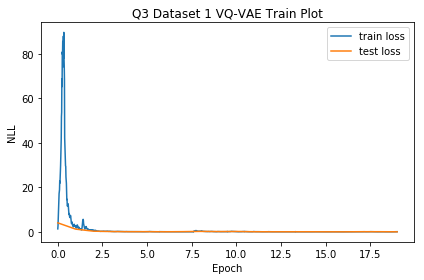

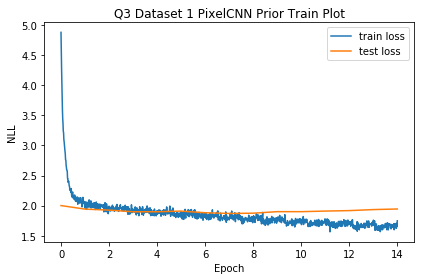

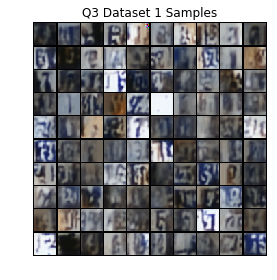

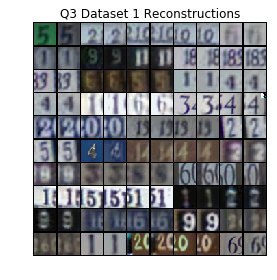

In [ ]:
q2_save_results(1, q2)

In [ ]:
q2_save_results(2, q2)

# Bonus 4

## Part (a) Improving VQ-VAE Results
Improve upon your results in Q2, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def b4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `b4_a`, execute the cells below to visualize and save your results.

In [ ]:
b4_a_save_results(2, b4_a)

## Part (b) PixelVAE
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def b4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """ 

### Results
Once you've finished `b4_b`, execute the cells below to visualize and save your results

In [ ]:
b4_b_save_results(b4_b)